[![image](https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png)](https://www.visual-layer.com)

# Analyzing Object Detection Dataset
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb)

In this tutorial, we will analyze an object detection dataset with bounding boxes and identify potential issues.

## Installation & Setting Up
This notebook is written to be run on Google Colab. If you're running fastdup locally, view the installation instructions for your operating system here.

In [2]:
!pip install -U fastdup plotly gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
  Attempting uninstall: fastdup
    Found existing installation: fastdup 1.2
    Uninstalling fastdup-1.2:
      Successfully uninstalled fastdup-1.2


## Download Dataset
We will be using the mini-coco dataset for this tutorial.

In [2]:
# Download images from mini-coco
!gdown --fuzzy https://drive.google.com/file/d/1iSXVTlkV1_DhdYpVDqsjlT4NJFQ7OkyK/view
!unzip -qq coco_minitrain_25k.zip

# Download csv annotations
!cd coco_minitrain_25k/annotations && gdown --fuzzy https://drive.google.com/file/d/1i12p23cXlqp1QrXjAD_vu467r4q67Mq9/view

Downloading...
From: https://drive.google.com/uc?id=1iSXVTlkV1_DhdYpVDqsjlT4NJFQ7OkyK
To: /content/coco_minitrain_25k.zip
100% 4.90G/4.90G [00:48<00:00, 100MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1i12p23cXlqp1QrXjAD_vu467r4q67Mq9
To: /content/coco_minitrain_25k/annotations/coco_minitrain2017.csv
100% 9.43M/9.43M [00:00<00:00, 11.7MB/s]


## Load annotations
We will use a simple converter to convert the COCO format JSON annotation file into the fastdup annotation dataframe. This converter is applicable to any dataset which uses COCO format.

In [3]:
import fastdup
fastdup.__version__

'1.3'

In [4]:
import pandas as pd

In [5]:
coco_csv = 'coco_minitrain_25k/annotations/coco_minitrain2017.csv'
coco_annotations = pd.read_csv(coco_csv, header=None, names=['filename', 'col_x', 'row_y',
                                                             'width', 'height', 'label', 'ext'])

coco_annotations['split'] = 'train'  # Only train files were loaded
coco_annotations['filename'] = coco_annotations['filename'].apply(lambda x: 'coco_minitrain_25k/images/train2017/'+x)
coco_annotations = coco_annotations.drop_duplicates()


In [6]:
coco_annotations.head(3)

filename   col_x   row_y   width  height   label  ext  split
0  coco_minitrain_25k/images/train2017/000000131075.jpg   20.23   55.98  313.49  326.50      tv    0  train
1  coco_minitrain_25k/images/train2017/000000131075.jpg  176.90  381.12  286.20  136.63  laptop    0  train
2  coco_minitrain_25k/images/train2017/000000131075.jpg  369.96  361.35   72.76   73.91  laptop    0  train

## Run fastdup

In [7]:
# Run fastdup with annotations
# This may take a while on a colab node with 2 cores..
input_dir = '.'
work_dir = 'fastdup_minicoco'

fd = fastdup.create(work_dir=work_dir, input_dir=input_dir)
fd.run(annotations=coco_annotations, overwrite=True, num_images=10000)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
fastdup C++ info received:  2023-05-20 04:46:25 [INFO] Going to loop over dir /tmp/tmpaeboyuub.csv
2023-05-20 04:46:26 [INFO] Found total 10000 images to run on, 10000 train, 0 test, name list 10000, counter 10000 
2023-05-20 04:48:59 [ERROR] Error: found invalid bounding box for image coco_minitrain_25k/images/train2017/000000528201.jpg. Please check bounding box file 264 341 0 5
Error: found invalid bounding box for image coco_minitrain_25k/images/train2017/000000528201.jpg. Please check bounding box file 264 341 0 5
 

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
fastdup C++ info received:  2023-05-20 04:50:46 [INFO] Going to loop over dir /tmp/crops_input.csv
2023-05-20 04:50:46 [INFO] Found total 9999 images to run on, 9999 train, 0 test, name list 9999, counter 9999 
2023-05-20 04:50:46 [ERROR] Missing file missing_file - file does not existMissing file missing_file - file doe

## Class distribution
The dataset contains 25k images and 183k objects, an average of 7.3 objects per image. 

Interestingly, we see a highly unbalanced class distribution, where all 80 coco classes are present here, but there is a strong balance towards the person class, that accounts for over 56k instances (30.6%). Car and Chair classes also contain over 8k instances each, while at the bottom of the list the toaster and hair drier classes contain as few as 40 instances. 

Using `Plotly` we get a useful interactive histogram. 

In [8]:
import plotly.express as px
fig = px.histogram(coco_annotations, x="label")
fig.show()

*italicized text*## Component gallery

laptop


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Finished OK. Components are stored as image files fastdup_minicoco/galleries/components_[index].jpg
Stored components visual view in  fastdup_minicoco/galleries/components.html
Execution time in seconds 3.1



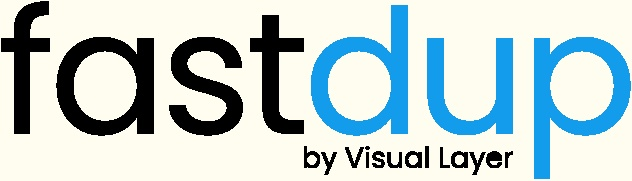
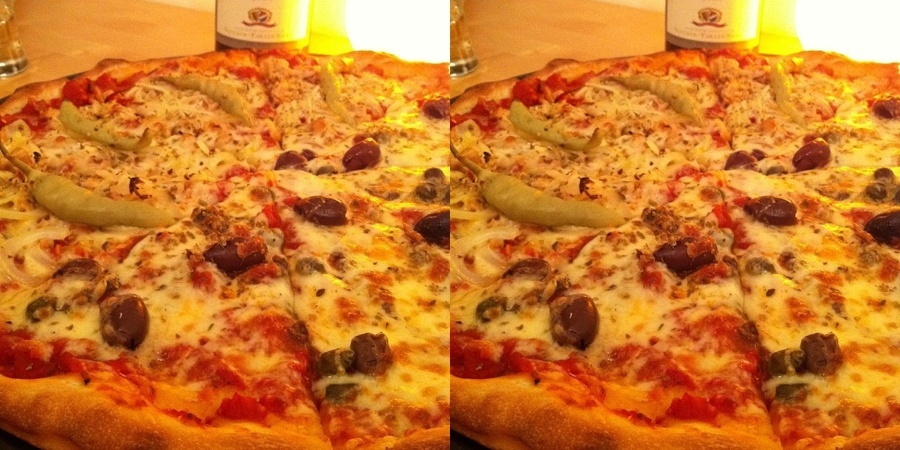
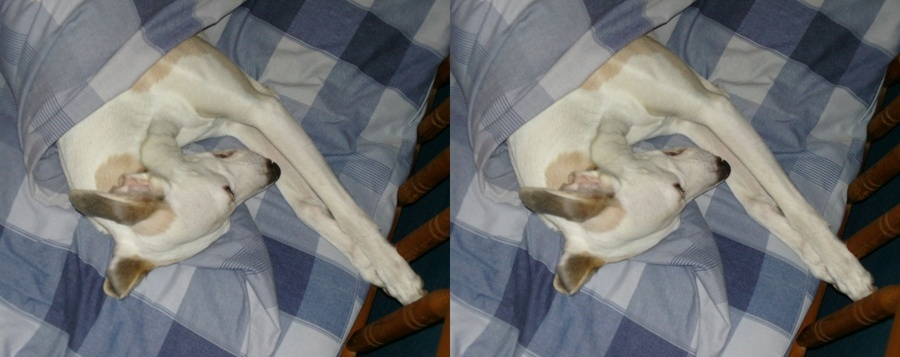
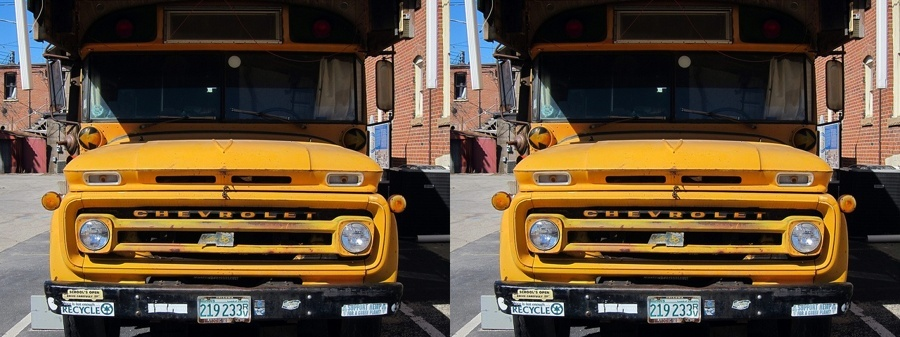
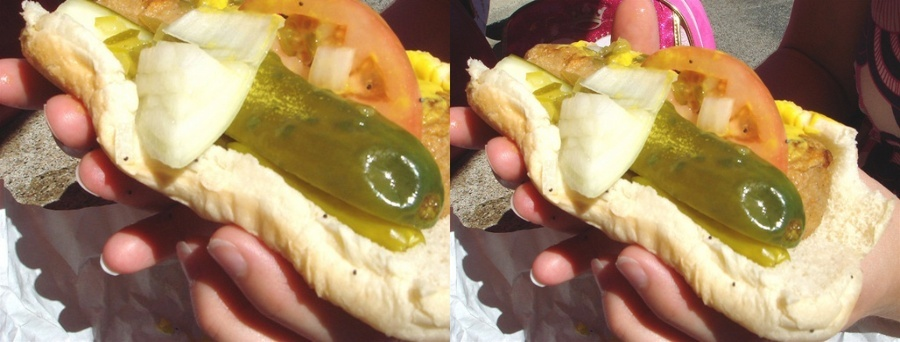
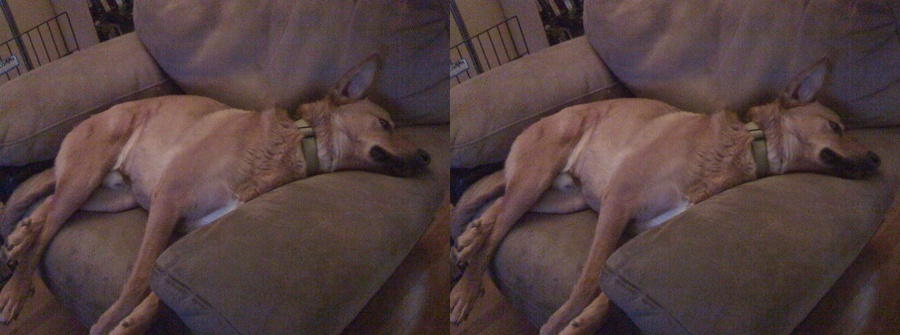
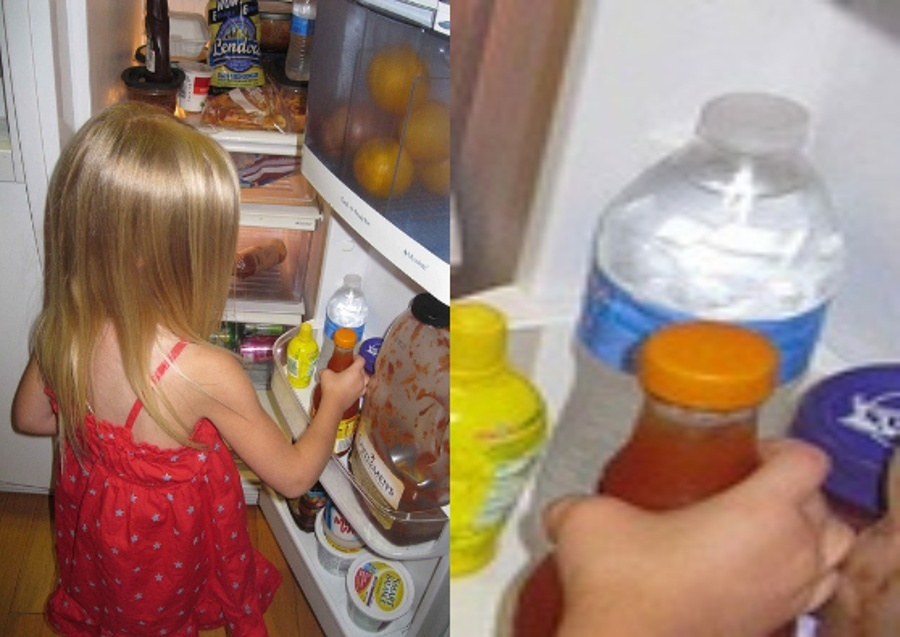
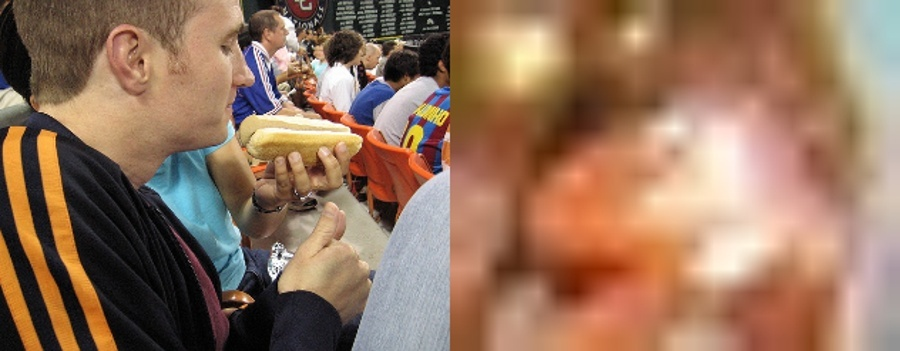
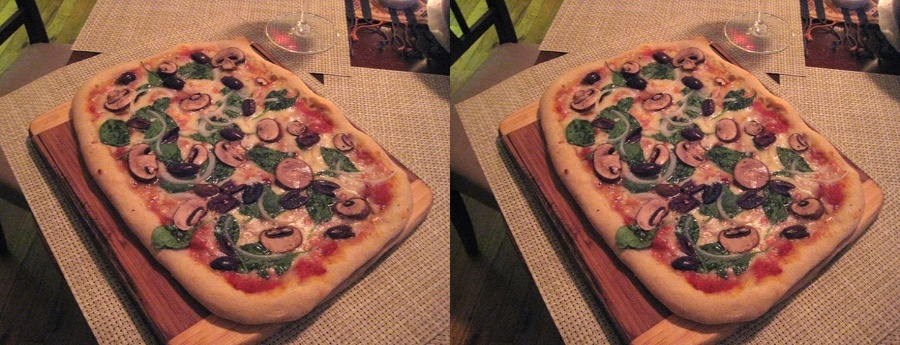
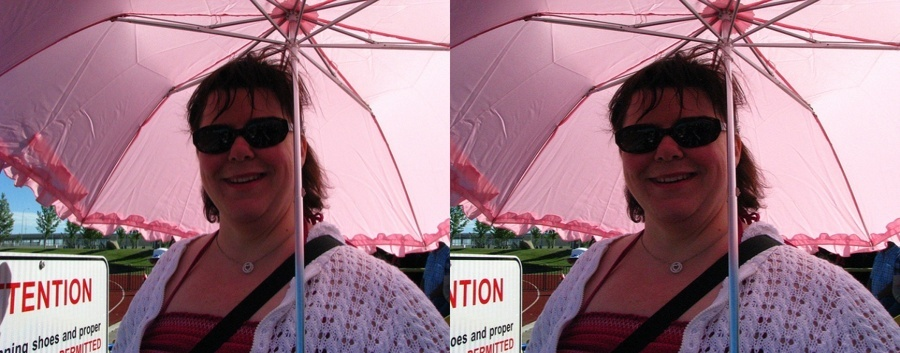
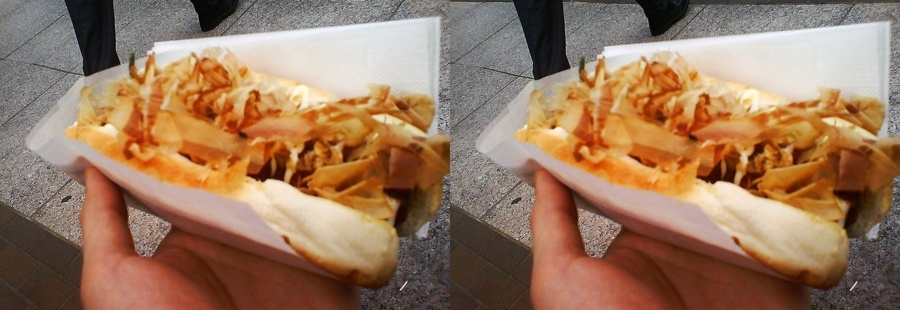
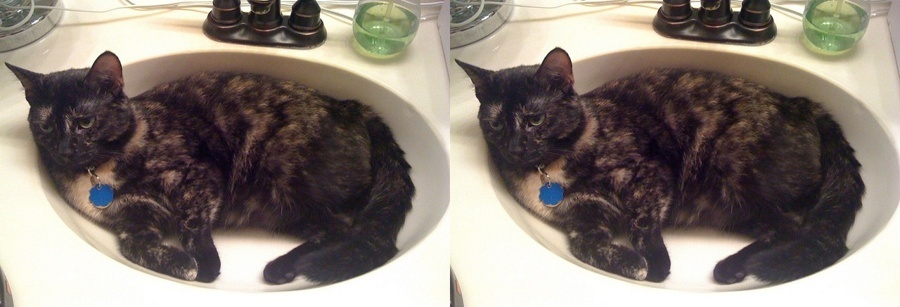
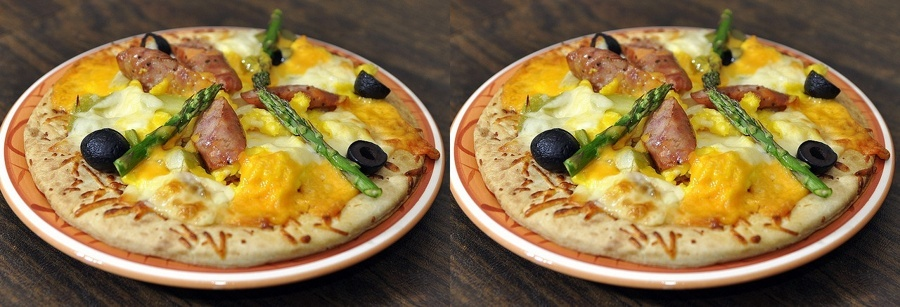
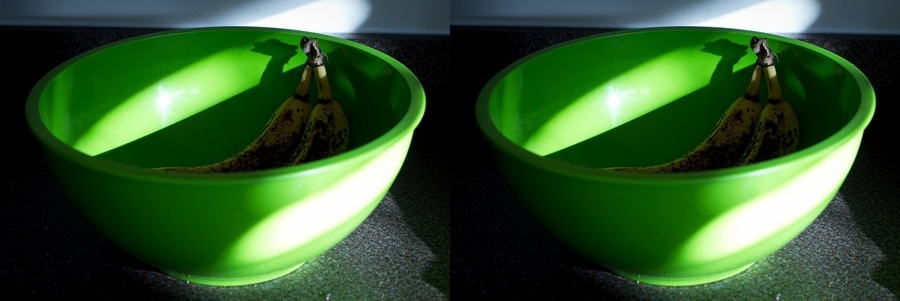
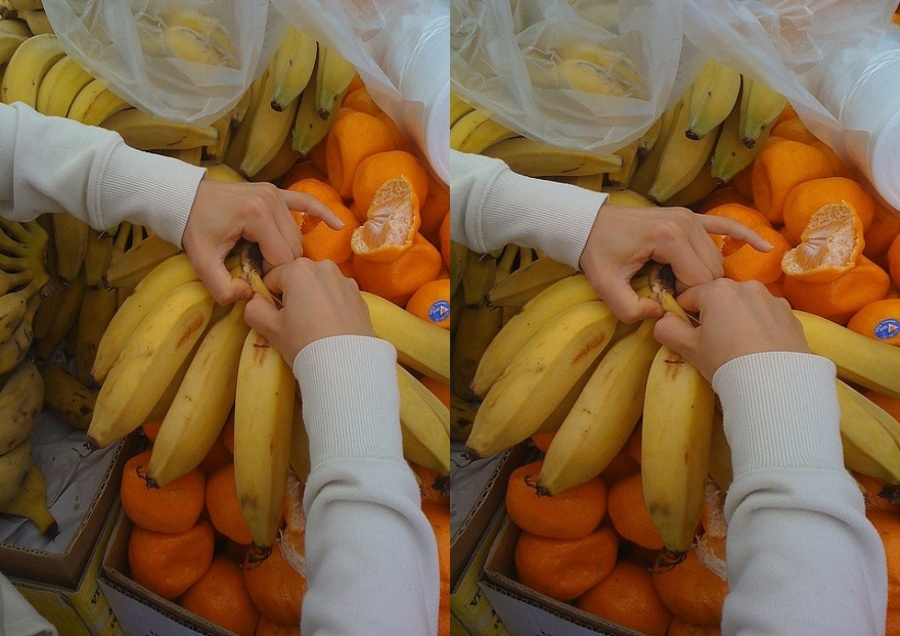
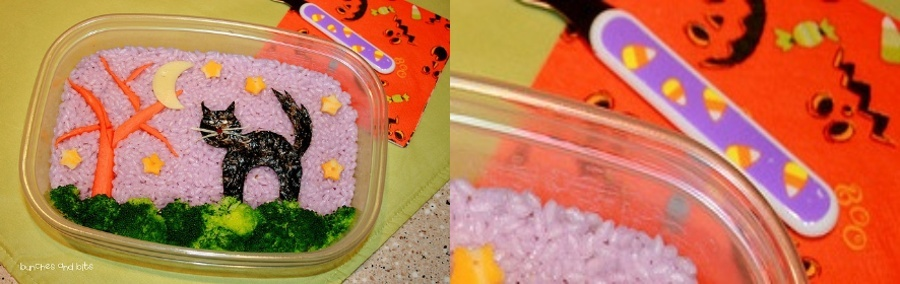
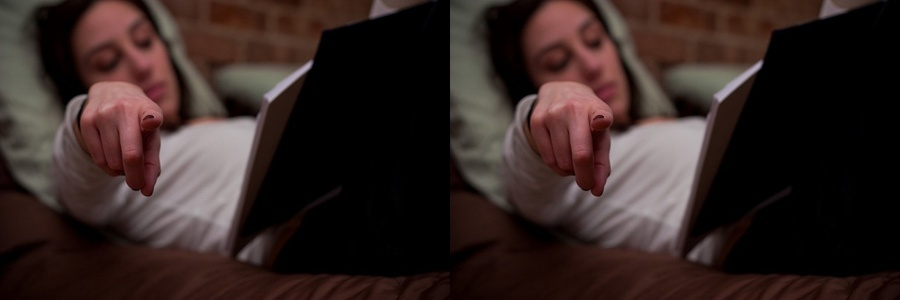
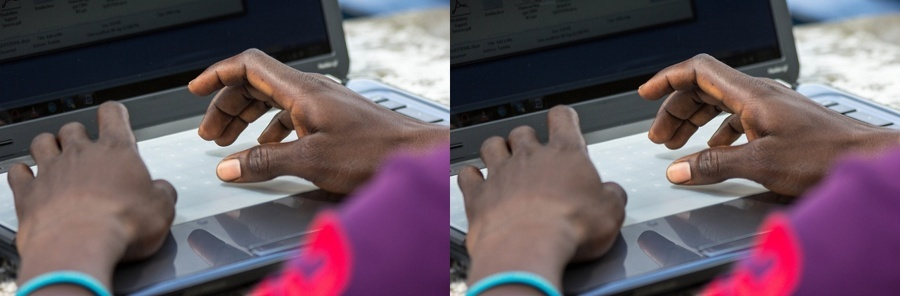
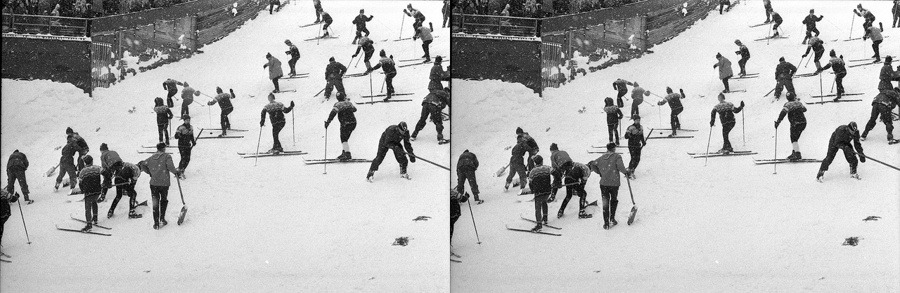
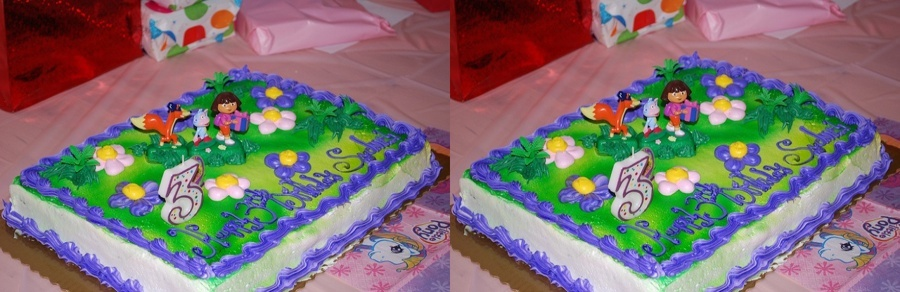
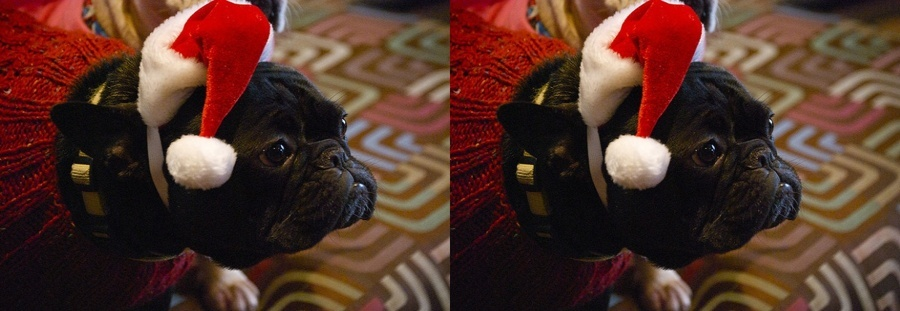

In [16]:
# sorting by largest objects
fd.vis.component_gallery(metric='size', max_width=900)

## Outliers

100%|██████████| 20/20 [00:00<00:00, 3189.46it/s]


Stored outliers visual view in  fastdup_minicoco/galleries/outliers.html



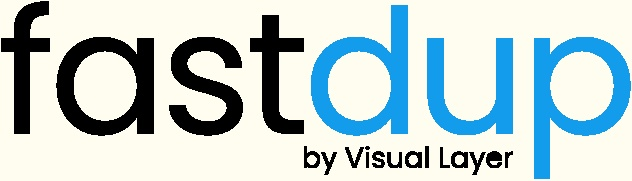
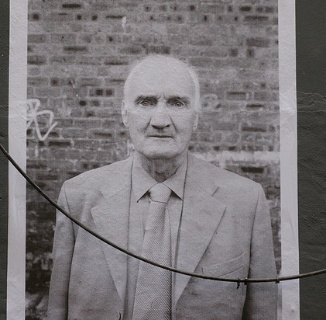
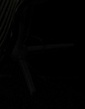
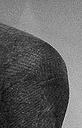
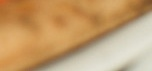
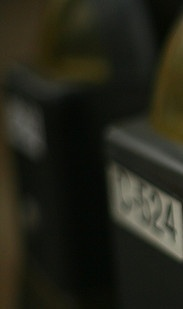
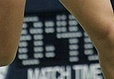
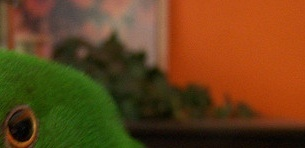
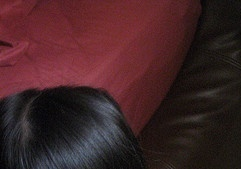
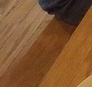
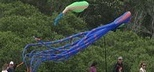
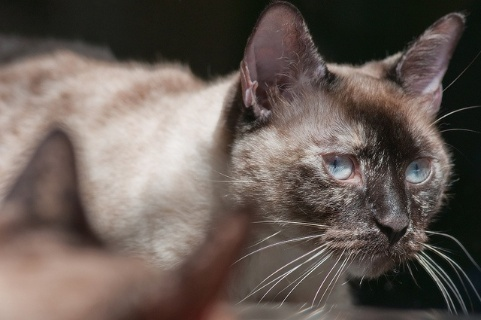
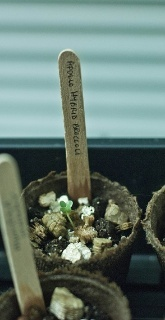
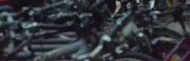
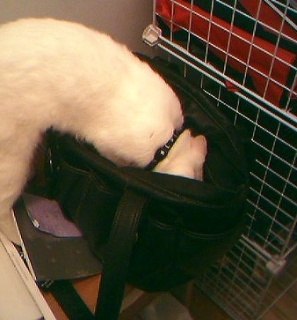
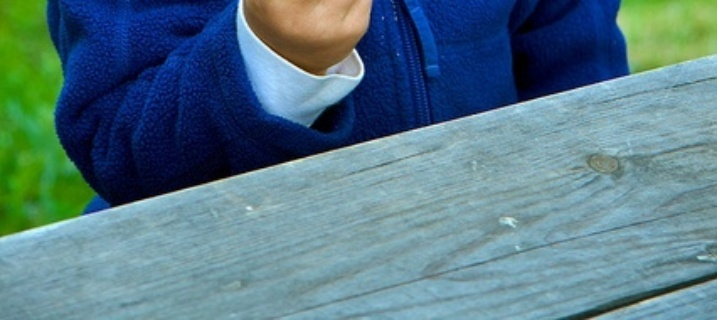
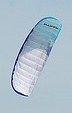
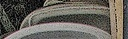
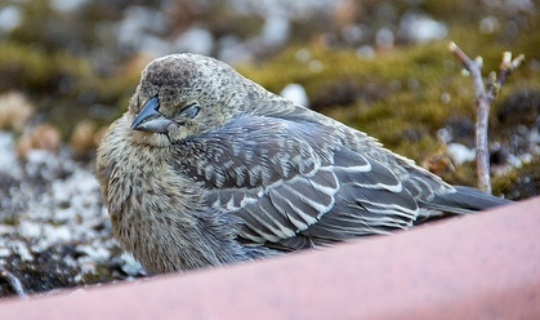
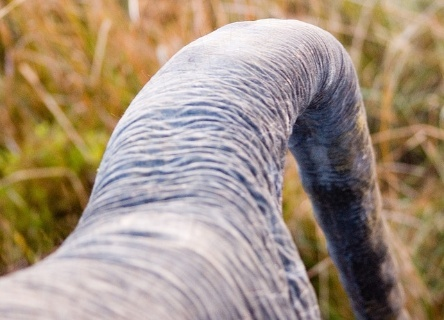
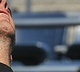

In [19]:
# visualize outliers
fd.vis.outliers_gallery()

## Size and shape issues
Objects come in various shapes and sizes, and sometimes objects might be incorrectly labeled or too small to be useful. We will now find the smallest, narrowest and widest objects, and asses their usefulness. 

In [22]:
annot = fd.annotations()
print(annot.head())
annot['area'] = annot['width_x'] * annot['height_x']
annot['aspect'] = annot['width_x'] / annot['height_x']

   col_x_x  row_y_x  width_x  height_x   label  ext  split  index                                              filename                                                                                 crop_filename  col_x_y  row_y_y  width_y  height_y error_code  is_valid  fd_index
0    20.23    55.98   313.49    326.50      tv    0  train      0  coco_minitrain_25k/images/train2017/000000131075.jpg    fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000131075.jpg_20_55_313_326.jpg      NaN      NaN      NaN       NaN      VALID      True         0
1   176.90   381.12   286.20    136.63  laptop    0  train      1  coco_minitrain_25k/images/train2017/000000131075.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000131075.jpg_176_381_286_136.jpg      NaN      NaN      NaN       NaN      VALID      True         1
2   369.96   361.35    72.76     73.91  laptop    0  train      2  coco_minitrain_25k/images/train2017/000000131075.jpg    fastdup_minicoco/crops/coco_min

<ipython-input-22-ec4cf4a5b389>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-ec4cf4a5b389>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# Smallest 5% of objects:
smallest_objects = annot[annot['area'] < annot['area'].quantile(0.05)].sort_values(by=['area'])

# 5% of extreme aspect ratios
aspect_ratio_objects = annot[(annot['aspect'] < annot['aspect'].quantile(0.05))
                             | (annot['aspect'] > annot['aspect'].quantile(0.95))].sort_values(by=['aspect'])


In [24]:
# let's see the smallest objects
smallest_objects.head(3)

col_x_x  row_y_x  width_x  height_x   label  ext  split  index                                              filename                                                                               crop_filename  col_x_y  row_y_y  width_y  height_y error_code  is_valid  fd_index      area    aspect
7882   510.70   100.68    10.13     10.13     cup    0  train   7882  coco_minitrain_25k/images/train2017/000000267216.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000267216.jpg_510_100_10_10.jpg      NaN      NaN      NaN       NaN      VALID      True      7882  102.6169  1.000000
3856   203.70   339.19    10.51     10.01     car    0  train   3856  coco_minitrain_25k/images/train2017/000000002529.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000002529.jpg_203_339_10_10.jpg      NaN      NaN      NaN       NaN      VALID      True      3856  105.2051  1.049950
1003   511.08   171.01    10.44     10.12  person    0  train   1003  coco_minitrain_25k/images/train2017/000000393978.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000393978.jpg_511_171_10_10.jpg      NaN      NaN      NaN       NaN      VALID      True      1003  105.6528  1.031621

In [25]:
aspect_ratio_objects.head(3)

col_x_x  row_y_x  width_x  height_x     label  ext  split  index                                              filename                                                                                crop_filename  col_x_y  row_y_y  width_y  height_y error_code  is_valid  fd_index       area    aspect
3642     1.92   136.50    11.51    263.87    person    0  train   3642  coco_minitrain_25k/images/train2017/000000002444.jpg    fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000002444.jpg_1_136_11_263.jpg      NaN      NaN      NaN       NaN      VALID      True      3642  3037.1437  0.043620
8332   626.64   135.36    13.15    159.64  umbrella    0  train   8332  coco_minitrain_25k/images/train2017/000000136415.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000136415.jpg_626_135_13_159.jpg      NaN      NaN      NaN       NaN      VALID      True      8332  2099.2660  0.082373
3591     0.00   133.02    19.37    219.55    person    0  train   3591  coco_minitrain_25k/images/train2017/000000002415.jpg    fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000002415.jpg_0_133_19_219.jpg      NaN      NaN      NaN       NaN      VALID      True      3591  4252.6835  0.088226

In [26]:
aspect_ratio_objects.tail(3)

col_x_x  row_y_x  width_x  height_x  label  ext  split  index                                              filename                                                                                crop_filename  col_x_y  row_y_y  width_y  height_y error_code  is_valid  fd_index        area     aspect
6006    89.05   212.44   486.91     24.63  train    0  train   6006  coco_minitrain_25k/images/train2017/000000397173.jpg   fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000397173.jpg_89_212_486_24.jpg      NaN      NaN      NaN       NaN      VALID      True      6006  11992.5933  19.768981
2021   221.00   180.00   305.00     15.00    car    0  train   2021  coco_minitrain_25k/images/train2017/000000001408.jpg  fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000001408.jpg_221_180_305_15.jpg      NaN      NaN      NaN       NaN      VALID      True      2021   4575.0000  20.333333
4261    33.00   216.00   602.00     18.00   boat    0  train   4261  coco_minitrain_25k/images/train2017/000000527098.jpg   fastdup_minicoco/crops/coco_minitrain_25kimagestrain2017000000527098.jpg_33_216_602_18.jpg      NaN      NaN      NaN       NaN      VALID      True      4261  10836.0000  33.444444

Look at that! The slices reveal many items that are either tiny (10x10 pixels) or have extreme aspect ratios - as extreme at 1:45 - an object 601 pixels wide by only 13 pixels high. 

## Objects that didn't make the cut:
Let's look at objects deemed invalid by fastdup. These are either objects that are too small to be useful in our analysis (smaller than 10px), have bouding boxes with illeagal values (negative or beyond image boundaries), or are part of images that are missing. We can tell which is which by the `error_code` column in our dataframe.

In [27]:
fd.invalid_instances().head(3)

col_x_x  row_y_x  width_x  height_x   label  ext  split  index filename crop_filename  col_x_y  row_y_y  width_y  height_y              error_code  is_valid  fd_index
0   437.17   244.79    19.52      9.93   mouse    0  train     16      NaN           NaN      NaN      NaN      NaN       NaN  ERROR_BAD_BOUNDING_BOX     False        16
1   137.84   332.22     8.92     11.50  person    0  train     60      NaN           NaN      NaN      NaN      NaN       NaN  ERROR_BAD_BOUNDING_BOX     False        60
2   177.35   294.13     5.32     11.92  person    0  train     65      NaN           NaN      NaN      NaN      NaN       NaN  ERROR_BAD_BOUNDING_BOX     False        65

## Distribution of error codes:
A simple `value_counts` will tell us the distribution of the errors. We have found 18,592 (!) bounding boxes that are either too small or go beyond image boundaries. This is 10% of the data! Filtering them would both save us grusome debugging of training errors and failures and help up provide the model with useful size objects. 

In [28]:
fd.invalid_instances()['error_code'].value_counts()

ERROR_MISSING_FILE        173544
ERROR_BAD_BOUNDING_BOX       933
Name: error_code, dtype: int64

## Find possible mislabels
The fastdup similarity search and gallery is a strong tool for finding objects that are possibly mislabeled. By finding each object's nearest neighbors and their classes, we can find objects with classes contradicting their neighbors' - a strong sign for mislabels.

laptop


100%|██████████| 25/25 [00:00<00:00, 77.16it/s]


Finished OK. Components are stored as image files fastdup_minicoco/galleries/components_[index].jpg
Stored components visual view in  fastdup_minicoco/galleries/components.html
Execution time in seconds 1.9



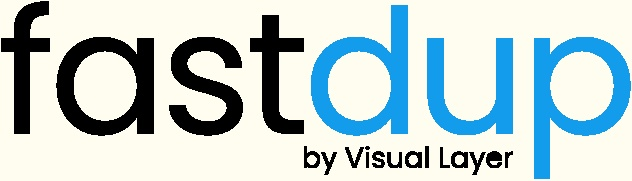
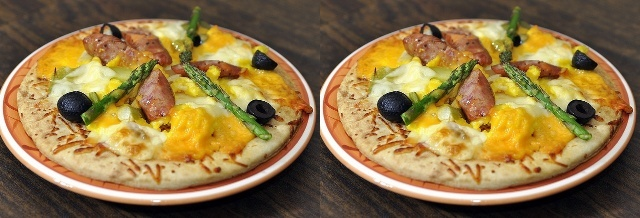
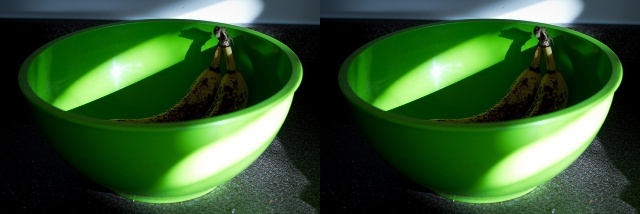
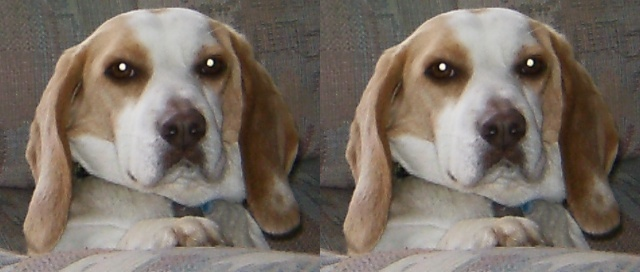
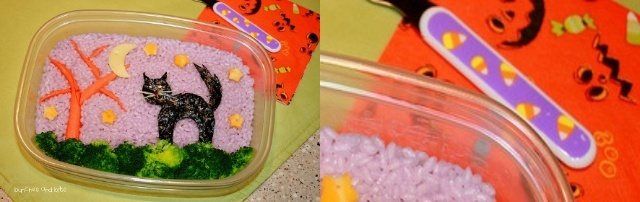
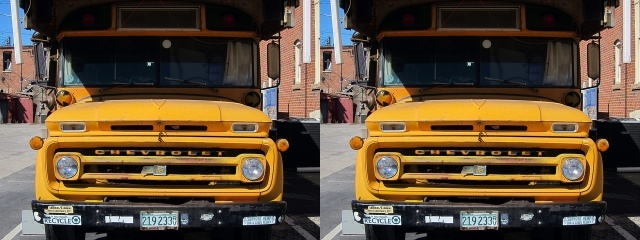
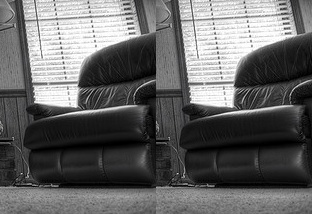
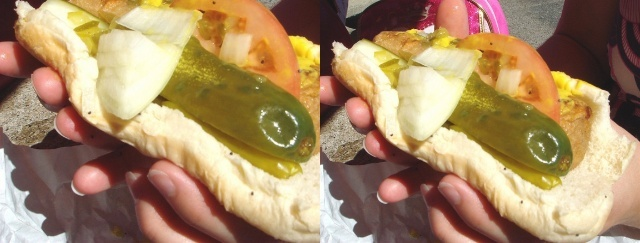
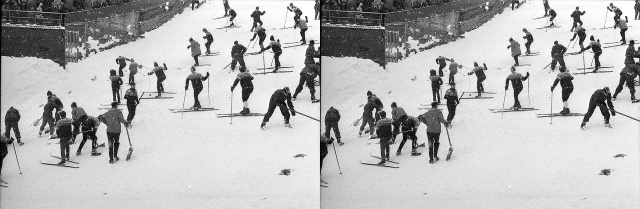
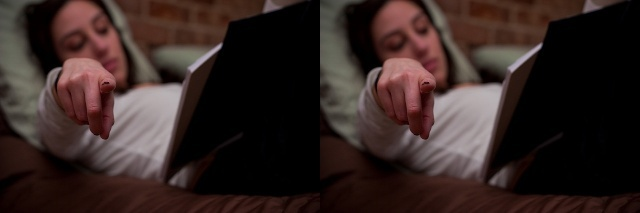
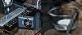
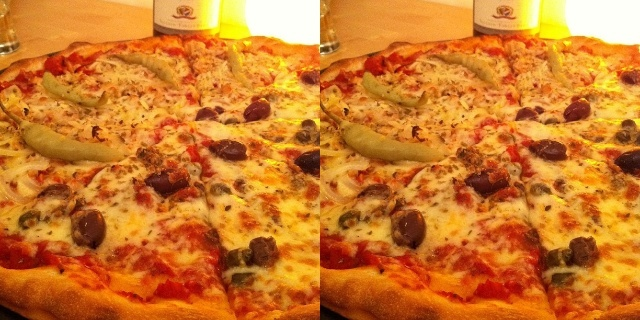
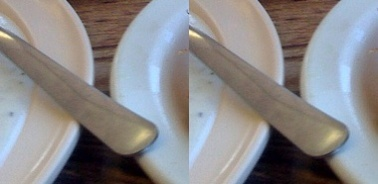
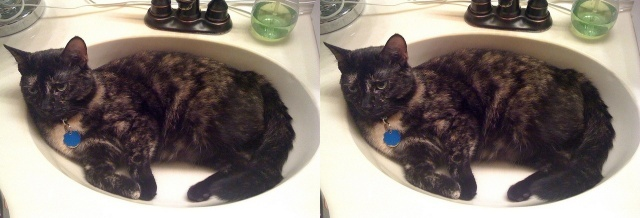
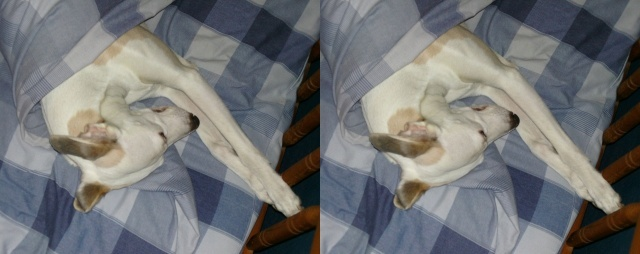
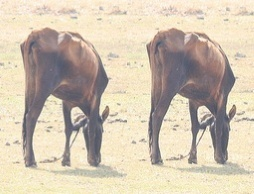
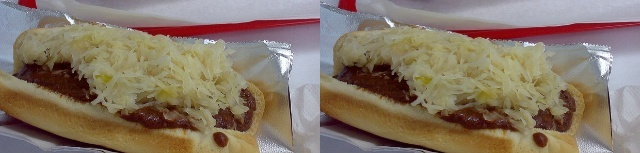
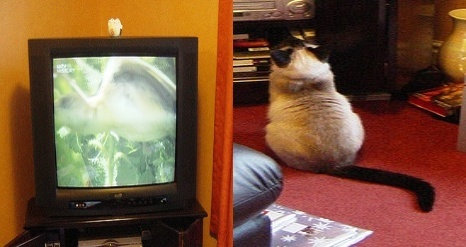
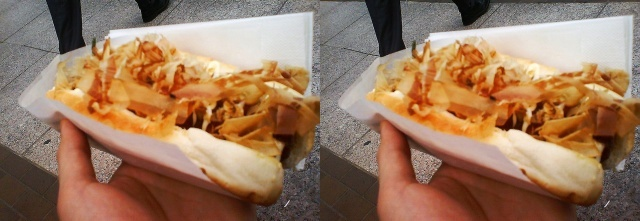
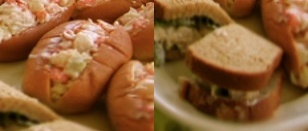
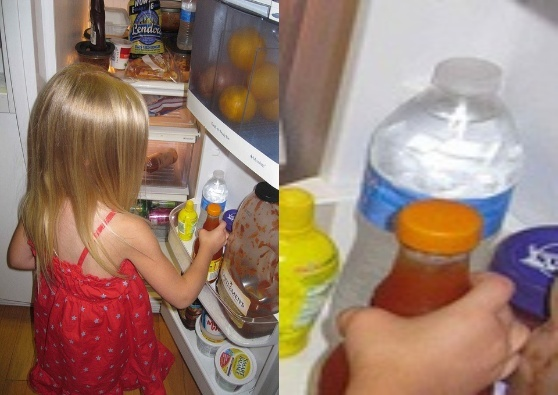
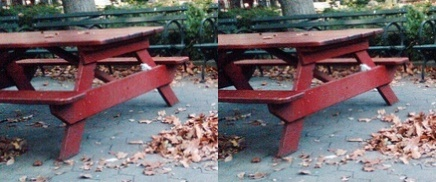
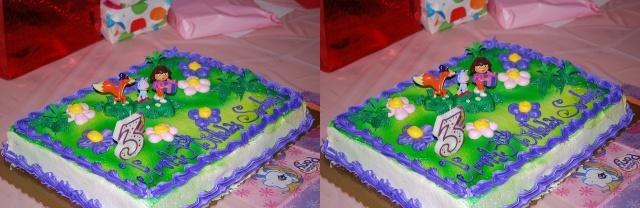
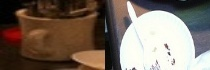
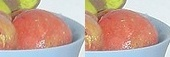
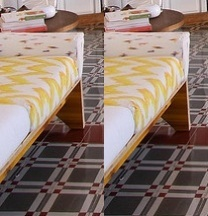

In [29]:
fd.vis.component_gallery(num_images=25, slice='diff')

## Wrap Up

Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try. 


## VL Profiler
If you prefer a no-code platform to inspect and visualize your dataset, [**try our free cloud product VL Profiler**](https://app.visual-layer.com) - VL Profiler is our first no-code commercial product that lets you visualize and inspect your dataset in your browser. 

[Sign up](https://app.visual-layer.com) now, it's free.

[![image](https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/vl_profiler_promo.svg)](https://app.visual-layer.com)

As usual, feedback is welcome! 

Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).